# Temporal Clustering, Melody and Chord Generation Notebook

## Overview

This Jupyter notebook explores the application of music theory principles, like **temporal clustering** and **chord generation**, to analyze and interpret plant data. The notebook is structured to guide you through the processing of time-series plant data, using musical analogies to discover patterns and generate representations.

## Sections

### 1. **Temporal Clustering**
- **Purpose**: To segment plant data over time into meaningful clusters based on defined spectral features of the data.
- **Process**: The notebook uses temporally-constrained agglomerative clustering from the Librosa library

### 2. **Generation of Melodies**
- **Purpose**: To transform clustered data into melodies, providing a unique auditory representation of the data patterns.
- **Process**: Each cluster's spectral centroids are converted into a sequence of notes.

### 3. **Generation of Chords**
- **Purpose**: To synthesize chords from the temporal clusters, further enhancing the musical representation of the plant data.
- **Process**: Chords are generated based on the spectral relationships found within clusters, offering a harmonic context to the previously created melodies.

## Getting Started

- **Run the Notebook**: Execute each cell sequentially to understand the flow from raw data to musical synthesis.
- **Explore Modifications**: Adjust the parameters or data inputs to see how the clustering changes and impacts the generated music.
- **Listen and Analyze**: Use the generated MIDI files to listen to the data and reflect on the auditory patterns that correspond to plant behaviors.

This notebook is intended for those interested in a multidisciplinary approach to data analysis, combining elements of **music theory** and **data science** to provide a fresh perspective on plant data interpretation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import functions from the utils.py in the ../scripts folder
import sys
sys.path.append('../scripts')
from utils import segment_time_series
folderpath = '../plant_data/Hiver 2024/Fichier RAW/'
filename = 'Acer pensylvanicum 2024-02-28.raw'
# get all filenames in the folder that ends with .raw
filenames = [f for f in os.listdir(folderpath) if f.endswith('.raw')]
sf = 256

## Temporal Clustering using Spectral Centroid

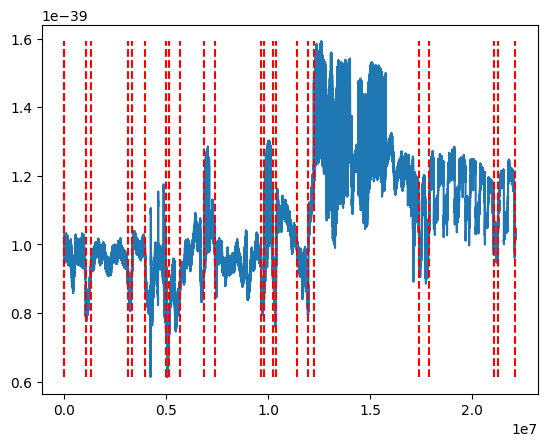

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def generate_segments(data, n_segments=64):
    feature = librosa.feature.spectral_centroid(y=data, sr=sf, n_fft=2000)
    bounds = librosa.segment.agglomerative(feature, n_segments)
    bound_times = librosa.frames_to_time(bounds, sr=sf)
    bound_times = sf*bound_times
    segments = segment_time_series(data, bound_times)
    segments = [segment[~np.isnan(segment)] for segment in segments]
    return segments, bound_times



# show example with a random file
filename = filenames[1]
data = np.fromfile(folderpath + filename, dtype=np.float32)
data = data[~np.isnan(data)]
segments, bound_times = generate_segments(data, n_segments=24)


# plot the time series and the change points
plt.plot(data)
plt.vlines(bound_times, data.min(), data.max(), color='r', linestyle='--', label='Change Points')
plt.show()



## Melody from averaged spectral centroids across segments

In [4]:
from mido import Message, MidiFile, MidiTrack

def freq2midi(frequency):
    return 69 + 12*np.log2(frequency/440)

def compute_avg_spectral_centroid(segments):
    spectral_centroids = []
    sc_avg = []
    sc_range = []
    for segment in segments:
        spectral_centroids.append(librosa.feature.spectral_centroid(y=segment, sr=sf, n_fft=2000)[0])
        sc_avg.append(np.nanmean(spectral_centroids[-1]))
        sc_range.append(np.nanmax(spectral_centroids[-1]) - np.nanmin(spectral_centroids[-1]))
    return sc_avg, sc_range

def compute_avg_spectral_rolloff(segments):
    spectral_rolloffs = []
    sr_avg = []
    for segment in segments:
        spectral_rolloffs.append(librosa.feature.spectral_rolloff(y=segment, sr=sf, n_fft=2000)[0])
        sr_avg.append(np.nanmean(spectral_rolloffs[-1]))
    return sr_avg


def generate_melody(freqs, velocities, bound_times, n_oct_up=6, filename='test', max_beat_duration=2):
    # Rescale velocities to MIDI velocity range (10 to 110)
    sc_range_rescaled = np.interp(velocities, (np.nanmin(velocities), np.nanmax(velocities)), (10, 110))
    sc_range_rescaled = [int(vel) for vel in sc_range_rescaled]

    # Shift all frequency values by n octaves
    sc_avg_shifted = np.array(freqs) * 2**n_oct_up
    midi_notes = [freq2midi(sc) for sc in sc_avg_shifted]
    midi_notes = [max(0, note) for note in midi_notes]  # Ensure no negative MIDI note numbers

    # Create MIDI file with the notes and corresponding timestamps
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    # Compute durations between each note
    bound_times_rescaled = bound_times / bound_times[-1] * 1000
    n_chords = len(bound_times_rescaled)
    durations = [bound_times_rescaled[i+1]-bound_times_rescaled[i] for i in range(n_chords-1)]
    # rescale durations between 0.1 and 2
    durations = [d/np.max(durations) for d in durations]
    durations = [d*max_beat_duration for d in durations]
    print(durations)
    
    current_time = 0
    # Append note events to track
    for i, duration in zip(range(n_chords), durations):
        try:
            track.append(Message('note_on', note=int(midi_notes[i]), velocity=int(sc_range_rescaled[i]), time=1))
            track.append(Message('note_off', note=int(midi_notes[i]), velocity=int(sc_range_rescaled[i]), time=int(duration * 480)))
            #current_time = current_time + int(duration * 480)
        except IndexError:
            pass

    # Save the MIDI file
    mid.save(f'../plant_music/spectral_centroid_melodies_sustained/SC_mel_{filename}.mid')
    

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# create folder 'spectral_centroid_melodies' in plant_music folder
if not os.path.exists('../plant_music/spectral_centroid_melodies_sustained'):
    os.makedirs('../plant_music/spectral_centroid_melodies_sustained')
    
# generate melodies for all files
n_oct_up = 6
for filename in filenames:
    data = np.fromfile(folderpath + filename, dtype=np.float32)
    data = data[~np.isnan(data)]
    if len(data) < 256:
        continue
    segments, bound_times = generate_segments(data, n_segments=24)
    sc_avg, sc_range = compute_avg_spectral_centroid(segments)
    print(filename)
    generate_melody(sc_avg, sc_range, bound_times, n_oct_up, filename=filename, max_beat_duration=8)

## Generate chords based on Spectral Peaks

#### Define the functions

In [6]:

from biotuner.biotuner_object import compute_biotuner
from biotuner.peaks_extraction import EMD_eeg
from biotuner.biotuner_utils import chords_to_ratios
from biotuner.biotuner_utils import create_midi, rebound


def extract_chords(segments, method='cepstrum', n_peaks=5, peaks_idxs=None, precision=0.01):
    """
    Extract chords from segments using spectral peaks detection.
    
    Parameters
    ----------
    segments : list of 1D arrays
        List of segments to extract chords from.
    method : str
        Method to use for peaks detection.
        Options are 'cepstrum' and 'EMD'. Default is 'cepstrum'.
    n_peaks : int
        Number of peaks to extract. Default is 5.
    peaks_idxs : list of ints
        List of indexes of peaks to extract when using EMD method. Default is None.
    precision : float
        Precision of the peaks detection. Default is 0.01.
        
    Returns
    -------
    chords : list of lists
        List of extracted chords.
    """
    # remove nans from segments
    chords = []
    for segment in segments[1:]:
        #print('segment size:', segment.size)
        if segment.size < 256:
            continue
        if np.isnan(segment).any():
            segment = segment[~np.isnan(segment)]
        #normalize segment between 0 and 1
        segment = (segment - np.nanmin(segment)) / (np.nanmax(segment) - np.nanmin(segment))
        try:
            bt = compute_biotuner(sf=sf, data=segment, peaks_function=method, precision=precision)
            bt.peaks_extraction(min_freq=0.001, max_freq=100, n_peaks=n_peaks, nIMFs=n_peaks)
            #print(bt.peaks)
        except ValueError:
            continue
        chord=[]
        if peaks_idxs is not None:
            for i in peaks_idxs:
                if i < len(bt.peaks):
                    chord.append(bt.peaks[i])
        else:
            chord = bt.peaks[1:]
        chords.append(chord)
    return chords

def chords_to_MIDI(chords, bound_times, n_oct_up=7, max_beat_duration=1.5, foldername='test', fname='test_chords', microtonal=True):
    """
    Convert chords to MIDI file.
    
    Parameters
    ----------
    chords : list
        List of chords to convert to MIDI.
    bound_times : list
        List of time stamps for each chord.
    n_oct_up : int
        Number of octaves to shift the chords up. Default is 7.
    max_beat_duration : float
        Maximum beat duration. Default is 1.5.
    foldername : str
        Name of the folder to save the MIDI file. Default is 'test'.
    fname : str
        Name of the MIDI file. Default is 'test_chords'.
    microtonal : bool
        If True, use microtonal MIDI. Default is True.
    
    Returns
    -------
    midi_file : MIDI file
        MIDI file of the chords.
    """
    n_chords = len(chords)
    mult = 2**n_oct_up
    new_chords = []
    for chord in chords[1:n_chords]:
        # Take the original frequencies and rebound them within one octave range
        c = [rebound(x, low=np.min(chord)-1, high=np.min(chord)*2, octave=2) for x in chord]
        # Then, move the chord n octaves up to be in the hearing range
        c = [np.int(x*mult) for x in c]
        new_chords.append(c)

    bound_times_rescaled = bound_times / bound_times[-1] * 1000
    durations = [bound_times_rescaled[i+1]-bound_times_rescaled[i] for i in range(n_chords-1)]
    # rescale durations between 0.1 and 2
    durations = [d/np.max(durations) for d in durations]
    durations = [d*max_beat_duration for d in durations]
    if not os.path.exists(f'../plant_music/spectral_chords/{foldername}'):
        os.makedirs(f'../plant_music/spectral_chords/{foldername}')
    fname = f"../plant_music/spectral_chords/{foldername}/{fname}"
    print('DURATIONS', durations)
    print('FILENAME', fname)
    midi_file = create_midi(new_chords, durations, subdivision=1, microtonal=microtonal, filename=fname)
    return midi_file

#### Generate the MIDI files for EMD and Cepstrum methods

In [7]:
# avoid printing warnings
import warnings
warnings.filterwarnings("ignore")

methods = ['EMD', 'cepstrum']
precisions = [0.01, 0.1]
for method, precision in zip(methods, precisions):
    for filename in filenames:
        fname = f"../plant_music/spectral_chords/{method}/{filename}.mid"
        # check if fname already exists
        if os.path.exists(fname):
            continue
        else:
            data = np.fromfile(folderpath + filename, dtype=np.float32)
            data = data[~np.isnan(data)]
            if len(data) < 256*60:
                continue
            segments, bound_times = generate_segments(data, n_segments=24)
            chords = extract_chords(segments, method=method, n_peaks=10, peaks_idxs=[3, 4, 5, 6, 7], precision=precision) 
            chords_to_MIDI(chords,  bound_times, n_oct_up=10, fname=filename, foldername=method, microtonal=False, max_beat_duration=8)
            
            

DURATIONS [0.0015880893300248141, 1.6095285359801492, 0.4065508684863523, 2.7958312655086854, 0.33032258064516157, 0.9973200992555827, 1.5571215880893303, 0.2636228287841191, 0.8528039702233262, 1.8215384615384613, 0.8123076923076914, 3.520794044665014, 0.24774193548387022, 0.6312655086848656, 0.25806451612903186, 1.5872952853598037, 0.8694789081885811, 0.4184615384615421, 8.0, 0.7908684863523573, 4.884168734491316, 0.31841191066997643, 1.3260545905707188]
FILENAME ../plant_music/spectral_chords/EMD/Acer pensylvanicum 2024-02-28.raw
DURATIONS [1.8413840830449828, 1.353079584775086, 3.3129411764705896, 1.0386159169550169, 0.3028373702422148, 0.04096885813148736, 0.19543252595155688, 1.0292041522491355, 0.10242214532871975, 0.07363321799307958, 0.5248442906574383, 0.4589619377162642, 0.0055363321799305415, 0.012179930795847192, 0.37923875432526033, 0.7424221453287201, 0.06588235294117548, 0.6350173010380622, 8.0, 1.3763321799307962, 0.44678200692041836, 1.0973010380622805, 0.730795847750

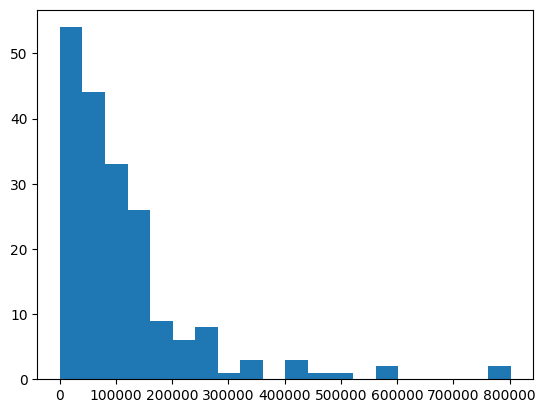

22117789


In [ ]:
# plot distribution of len of segments
len_segments = [len(segment) for segment in segments]
plt.hist(len_segments, bins=20)
plt.show()
print(len(data))